In [1]:
import numpy as np
import pandas as pd
from ast import literal_eval
from pathlib import Path
from src.utils import construct_sparse_adj_mat, load_json
from omegaconf import OmegaConf
from src.similarity import rcmcs_similarity_matrix
import matplotlib.pyplot as plt

In [2]:
arr = np.array([1, 2, 3, 4, 5])
rc = ((1,2,3),)

df = pd.DataFrame([[list(arr), rc]], columns=['A', 'B'])
df.head()

,A,B
0,"[1, 2, 3, 4, 5]","((1, 2, 3),)"


In [3]:
df.loc[0, 'A']

[1, 2, 3, 4, 5]

In [4]:
df.to_csv('test.csv', index=False)

In [5]:
ldf = pd.read_csv('test.csv')
ldf.head()

,A,B
0,"[1, 2, 3, 4, 5]","((1, 2, 3),)"


In [6]:
ldf.loc[0, 'A']

'[1, 2, 3, 4, 5]'

In [7]:
ldf.loc[0, 'B']

'((1, 2, 3),)'

In [8]:
ldf['A']

0    [1, 2, 3, 4, 5]
Name: A, dtype: object

In [9]:
ldf['A'] = ldf['A'].apply(lambda x : np.array(literal_eval(x)))
ldf['B'] = ldf['B'].apply(literal_eval)

In [10]:

ldf.loc[0, 'A'], type(ldf.loc[0, 'A'])

(array([1, 2, 3, 4, 5]), numpy.ndarray)

In [11]:
ldf.loc[0, 'B'], type(ldf.loc[0, 'B'])

(((1, 2, 3),), tuple)

In [12]:
filepaths = OmegaConf.load('../configs/filepaths/base.yaml')
reactions = load_json(Path(filepaths.data) / 'sprhea' / ('v3_folded_test' + ".json"))
rules = pd.read_csv(
            filepath_or_buffer=Path(filepaths.artifacts) / 'minimal1224_all_uniprot.tsv',
            sep='\t'
        )
rules.set_index('Name', inplace=True)
adj, idx_sample, idx_feature = construct_sparse_adj_mat(
        Path(filepaths.data) / 'sprhea' / ('v3_folded_test' + ".csv")
    )
reactions = {k: v for k, v in reactions.items() if k in idx_feature.values()}

Constructing v3_folded_test sparse adjacency matrix


In [13]:
len(reactions), len(idx_feature), adj.nonzero()[0].shape

(164, 164, (193,))

In [14]:
with open('test_embeddings.txt', 'w') as f:
    for pid in idx_sample.values():
        f.write(str(pid) + '\n')

In [65]:
data_dir = '/home/stef/quest_data/hiec/scratch/sprhea_v3_folded_test/rcmcs/3fold'

train_val = []
for i in range(3):
    train_val.append(
        pd.read_parquet(data_dir + '/train_val_' + str(i) + '.parquet')
    )
test = pd.read_parquet(data_dir + '/test.parquet')

In [66]:
train_val[0].head()

,protein_idx,reaction_idx,pid,rid,protein_embedding,smarts,reaction_center,y
0,49,67,P30930,1707,"[0.032134816, 0.18586083, -0.0042836606, -0.07...",CCCCCC=CCC=CCC=CCCCCCCC(=O)OC1CCC2(C)C(=CCC3C2...,"[[[19, 21], [20]], [[19, 21], [18]]]",1
1,22,31,Q5L2C2,9897,"[0.032134816, 0.18586083, -0.0042836606, -0.07...",O=CC(=O)O.CCN.OO>>CCNCC(=O)O.O.O=O,"[[[1, 0], [2], [0, 1]], [[3, 2], [0], [0, 1]]]",1
2,49,69,P30930,10663,"[0.032134816, 0.18586083, -0.0042836606, -0.07...",CCC=CCC=CCC=CCCCCCCCCCC(=O)OC1CCC2(C)C(=CCC3C2...,"[[[19, 21], [20]], [[19, 21], [18]]]",1
3,49,62,P30930,8862,"[0.032134816, 0.18586083, -0.0042836606, -0.07...",CCCCCC=CCC=CCC=CCC=CCCCC(=O)OC1CCC2(C)C(=CCC3C...,"[[[19, 21], [20]], [[19, 21], [18]]]",1
4,89,155,P70265,1795,"[0.032134816, 0.18586083, -0.0042836606, -0.07...",Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O)C(O)C1...,"[[[21], [11, 12]], [[9], [22, 23]]]",1


In [67]:
print([len(elt) for elt in train_val])
print(len(test))

[443, 389, 857]
47


In [68]:
S = rcmcs_similarity_matrix(
    reactions,
    rules,
    idx_feature
)

Preparing reaction pairs

Rxn # 162 : 50789
Processing pairs



100%|██████████| 689/689 [00:12<00:00, 55.91it/s] 


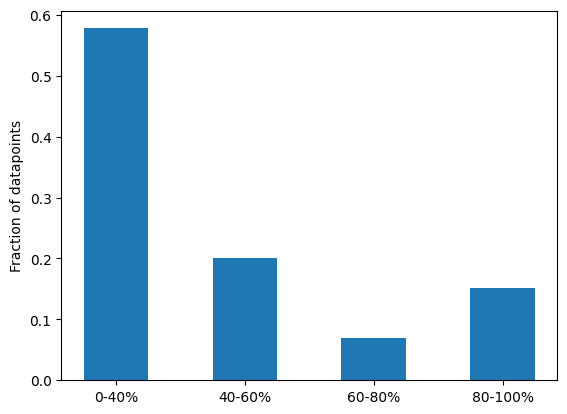

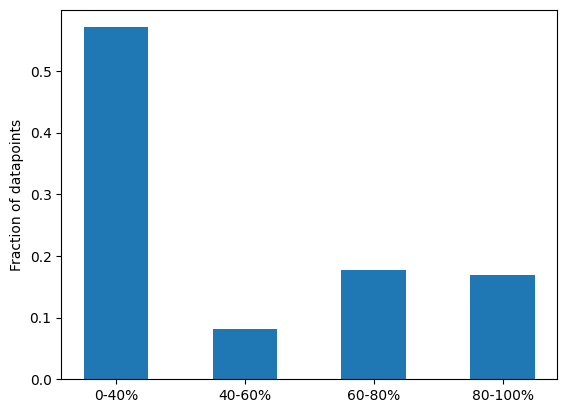

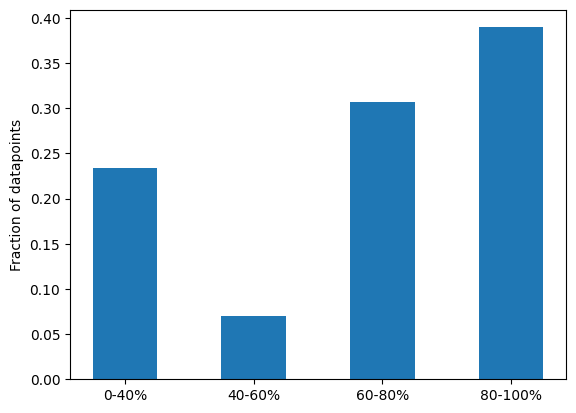

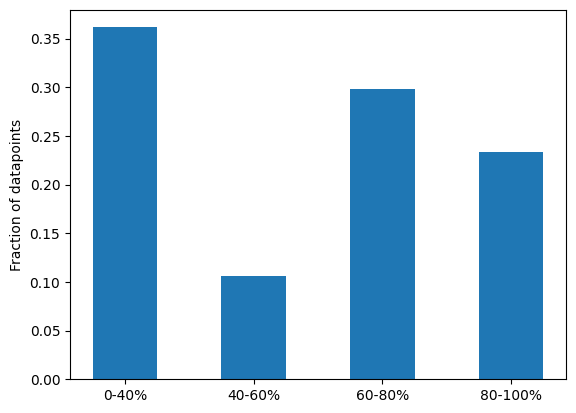

In [69]:
thresholds = [1.0, 0.8, 0.6, 0.4]
thresholds = sorted(thresholds)
xticklabels = [f"0-{thresholds[0]*100:.0f}%"] + [f"{thresholds[j]*100:.0f}-{thresholds[j+1]*100:.0f}%" for j in range(len(thresholds) - 1)]
for i, val in enumerate(train_val):
    val_ridx = val['reaction_idx'].values
    train = pd.concat([train_val[j] for j in range(3) if j != i])
    train_ridx = train['reaction_idx'].values
    max_sims = S[train_ridx][:, val_ridx].max(axis=0)
    cdf = []
    for j, th in enumerate(thresholds):
        if j == 0:
            in_range = len(np.argwhere(max_sims <= th))
        else:
            less_than_th = len(np.argwhere(max_sims <= th))
            less_than_prev = len(np.argwhere(max_sims <= thresholds[j - 1]))
            in_range = less_than_th - less_than_prev
        
        cdf.append(in_range / len(max_sims))

    plt.bar(thresholds, cdf, width=0.1, label='foo')
    plt.xticks(thresholds, xticklabels)
    plt.ylabel('Fraction of datapoints')
    plt.show()

val_ridx = test['reaction_idx'].values
train = pd.concat(train_val)
train_ridx = train['reaction_idx'].values
max_sims = S[train_ridx][:, val_ridx].max(axis=0)
cdf = []
for j, th in enumerate(thresholds):
    if j == 0:
        in_range = len(np.argwhere(max_sims <= th))
    else:
        less_than_th = len(np.argwhere(max_sims <= th))
        less_than_prev = len(np.argwhere(max_sims <= thresholds[j - 1]))
        in_range = less_than_th - less_than_prev
    
    cdf.append(in_range / len(max_sims))

plt.bar(thresholds, cdf, width=0.1, label='foo')
plt.xticks(thresholds, xticklabels)
plt.ylabel('Fraction of datapoints')
plt.show()

In [73]:
for i, elt in enumerate(train_val):
    print(f"Fold {i}")
    print("+", len(elt[elt['y'] == 1]) / len(elt))
    print("-", len(elt[elt['y'] == 0]) / len(elt))

print(f"Test")
print("+", len(test[test['y'] == 1]) / len(test))
print("-", len(test[test['y'] == 0]) / len(test))

Fold 0
+ 0.10158013544018059
- 0.8984198645598194
Fold 1
+ 0.10282776349614396
- 0.897172236503856
Fold 2
+ 0.09801633605600933
- 0.9019836639439907
Test
+ 0.5106382978723404
- 0.48936170212765956
